In [8]:
from os import listdir
from pickle import dump
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from numpy import argmax
import tensorflow as tf
from gtts import gTTS
import IPython
from IPython.display import Image, display

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

True

In [11]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [12]:
def extract_features(directory):
  # load the model
  model = VGG16()
  # re-structure the model
  model.layers.pop()
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
  # summarize
  print(model.summary())
  # extract features from each photo
  features = dict()
  for name in listdir(directory):
    # load an image from file
    filename = directory + '/' + name
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    # get image id
    image_id = name.split('.')[0]
    # store feature
    features[image_id] = feature
    print('>%s' % name)
  return features

 
# extract features from all images
directory = 'drive/My Drive/IC/Flicker8k_Dataset_Small'
features = extract_features(directory)
print('Extracted Features : %d' % len(features))
# save to file
dump(features, open('drive/My Drive/IC/features.pkl', 'wb'))

553467904/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [13]:
# Load data from text file
def load_doc(filename):
	# open the file as read only
  file = open(filename, 'r')
	# read all text
  text = file.read()
	# close the file
  file.close()
  return text



# load descriptions
filename = '/content/drive/MyDrive/IC/Flicker8k_token_Small.txt'
doc = load_doc(filename)
print(doc)

﻿667626_18933d713e.jpg#0        A girl is stretched out in shallow water
667626_18933d713e.jpg#1        A girl wearing a red and multi-colored bikini is laying on her back in shallow water .
667626_18933d713e.jpg#2        A little girl in a red swimsuit is laying on her back in shallow water .
667626_18933d713e.jpg#3        A young girl is lying in the sand , while ocean water is surrounding her .
667626_18933d713e.jpg#4        Girl wearing a bikini lying on her back in a shallow pool of clear blue water .
3637013_c675de7705.jpg#0        A couple stands close at the water 's edge .
3637013_c675de7705.jpg#1        The two people stand by a body of water and in front of bushes in fall .
3637013_c675de7705.jpg#2        Two people hold each other near a pond .
3637013_c675de7705.jpg#3        Two people stand by the water .
3637013_c675de7705.jpg#4        Two people stand together on the edge of the water on the grass .
10815824_2997e03d76.jpg#0        A blonde horse and a blonde girl in a 

In [14]:
# extract descriptions for images
def load_descriptions(doc):
  mapping = dict()
  # process lines
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    if len(line) < 2:
      continue
    # take the first token as the image id, the rest as the description
    image_id, image_desc = tokens[0], tokens[1:]
    # remove filename from image id
    image_id = image_id.split('.')[0]
    # convert description tokens back to string
    image_desc = ' '.join(image_desc)
    # create the list if needed
    if image_id not in mapping:
      mapping[image_id] = list()
    # store description
    mapping[image_id].append(image_desc)
  print(mapping)
  return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

{'\ufeff667626_18933d713e': ['A girl is stretched out in shallow water'], '667626_18933d713e': ['A girl wearing a red and multi-colored bikini is laying on her back in shallow water .', 'A little girl in a red swimsuit is laying on her back in shallow water .', 'A young girl is lying in the sand , while ocean water is surrounding her .', 'Girl wearing a bikini lying on her back in a shallow pool of clear blue water .'], '3637013_c675de7705': ["A couple stands close at the water 's edge .", 'The two people stand by a body of water and in front of bushes in fall .', 'Two people hold each other near a pond .', 'Two people stand by the water .', 'Two people stand together on the edge of the water on the grass .'], '10815824_2997e03d76': ['A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .', 'A girl and her horse stand by a fire .', "A girl holding a horse 's lead behind a fire .", 'A man , and girl and two horses are near a contained fire .', 'Two pe

In [15]:
import string
 
def clean_descriptions(descriptions):
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      # tokenize
      desc = desc.split()
      # convert to lower case
      desc = [word.lower() for word in desc]
      # remove punctuation from each token
      desc = [w.translate(table) for w in desc]
      # remove hanging 's' and 'a'
      desc = [word for word in desc if len(word)>1]
      # remove tokens with numbers in them
      desc = [word for word in desc if word.isalpha()]
      # store as string
      desc_list[i] =  ' '.join(desc)
 
# clean descriptions
clean_descriptions(descriptions)
print(descriptions)

{'\ufeff667626_18933d713e': ['girl is stretched out in shallow water'], '667626_18933d713e': ['girl wearing red and multicolored bikini is laying on her back in shallow water', 'little girl in red swimsuit is laying on her back in shallow water', 'young girl is lying in the sand while ocean water is surrounding her', 'girl wearing bikini lying on her back in shallow pool of clear blue water'], '3637013_c675de7705': ['couple stands close at the water edge', 'the two people stand by body of water and in front of bushes in fall', 'two people hold each other near pond', 'two people stand by the water', 'two people stand together on the edge of the water on the grass'], '10815824_2997e03d76': ['blonde horse and blonde girl in black sweatshirt are staring at fire in barrel', 'girl and her horse stand by fire', 'girl holding horse lead behind fire', 'man and girl and two horses are near contained fire', 'two people and two horses watching fire'], '12830823_87d2654e31': ['children sit and watc

In [16]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
  # build a list of all description strings
  all_desc = set()
  for key in descriptions.keys():
    [all_desc.update(d.split()) for d in descriptions[key]]
  return all_desc
 
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print(vocabulary)
print('Vocabulary Size: %d' % len(vocabulary))

{'surrounding', 'playing', 'wearing', 'sit', 'cart', 'puppet', 'wisks', 'hand', 'merchandise', 'children', 'decorated', 'to', 'inspect', 'stand', 'day', 'wooden', 'rows', 'walking', 'kayaker', 'edge', 'jacket', 'tiled', 'intersection', 'person', 'boat', 'meal', 'out', 'golden', 'mobile', 'food', 'items', 'vendor', 'hold', 'her', 'around', 'the', 'fishing', 'brightly', 'bicycle', 'red', 'under', 'walk', 'stare', 'past', 'man', 'watch', 'clear', 'near', 'dim', 'by', 'stands', 'next', 'police', 'tree', 'couple', 'through', 'machine', 'fall', 'barrel', 'corner', 'lying', 'three', 'are', 'behind', 'morning', 'busy', 'and', 'large', 'floor', 'play', 'city', 'bikini', 'at', 'grass', 'sweatshirt', 'paddle', 'fish', 'together', 'bank', 'several', 'on', 'people', 'blue', 'girl', 'shallow', 'small', 'pool', 'front', 'lake', 'theater', 'women', 'over', 'lead', 'pot', 'into', 'car', 'while', 'kayaks', 'camping', 'big', 'multicolored', 'wrestling', 'look', 'looking', 'foggy', 'sitting', 'staring', '

In [17]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + ' ' + desc)
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

# save descriptions
save_descriptions(descriptions, 'drive/My Drive/IC/descriptions.txt')

In [18]:
from pickle import load

# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

# load a pre-defined list of photo identifiers
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()
  # process line by line
  for line in doc.split('\n'):
    # skip empty lines
    if len(line) < 1:
      continue
    # get the image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
  # load document
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]
    # skip images not in the set
    if image_id in dataset:
      # create list
      if image_id not in descriptions:
        descriptions[image_id] = list()
      # wrap description in tokens
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      # store
      descriptions[image_id].append(desc)
  return descriptions

# load photo features (loading from pickle data)
def load_photo_features(filename, dataset):
  # load all features
  all_features = load(open(filename, 'rb'))
  # filter features
  features = {k: all_features[k] for k in dataset}
  return features

# load training dataset
filename = '/content/drive/My Drive/IC/Flickr8k_trainImages_Small.txt'
train = load_set(filename) # Training images name in "set" (dataset)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/content/drive/My Drive/IC/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('drive/My Drive/IC/features.pkl', train)
print('Photos: %d' % len(train_features))

Dataset: 10
Descriptions: train=10
Photos: 10


In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
  all_desc = list()
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
  lines = to_lines(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
print(tokenizer.word_index)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

{'startseq': 1, 'endseq': 2, 'in': 3, 'the': 4, 'people': 5, 'and': 6, 'on': 7, 'two': 8, 'water': 9, 'man': 10, 'is': 11, 'of': 12, 'girl': 13, 'are': 14, 'at': 15, 'by': 16, 'grass': 17, 'red': 18, 'her': 19, 'fire': 20, 'with': 21, 'street': 22, 'bench': 23, 'wearing': 24, 'stand': 25, 'near': 26, 'fish': 27, 'person': 28, 'around': 29, 'food': 30, 'sitting': 31, 'back': 32, 'shallow': 33, 'ocean': 34, 'pond': 35, 'horse': 36, 'children': 37, 'fishes': 38, 'tree': 39, 'large': 40, 'puppies': 41, 'walk': 42, 'vendor': 43, 'jacket': 44, 'cooking': 45, 'bikini': 46, 'laying': 47, 'young': 48, 'lying': 49, 'while': 50, 'pool': 51, 'blue': 52, 'couple': 53, 'edge': 54, 'body': 55, 'blonde': 56, 'horses': 57, 'watching': 58, 'several': 59, 'some': 60, 'foggy': 61, 'fishing': 62, 'kayaks': 63, 'boat': 64, 'wrestling': 65, 'playing': 66, 'background': 67, 'city': 68, 'puppet': 69, 'theater': 70, 'table': 71, 'multicolored': 72, 'little': 73, 'swimsuit': 74, 'sand': 75, 'surrounding': 76, 'c

In [20]:
from numpy import array
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
  X1, X2, y = list(), list(), list()
  # walk through each image identifier
  for key, desc_list in descriptions.items():
    # walk through each description for the image
    for desc in desc_list:
      # encode the sequence
      seq = tokenizer.texts_to_sequences([desc])[0]
      # split one sequence into multiple X,y pairs
      for i in range(1, len(seq)):
        # split into input and output pair
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # store
        X1.append(photos[key][0])
        X2.append(in_seq)
        y.append(out_seq)
  return array(X1), array(X2), array(y)

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

max_length = max_length(train_descriptions)
print("Maximum length of caption in dataset : ", max_length)

Maximum length of caption in dataset :  18


In [21]:
# define the captioning model
def define_model(vocab_size, max_length):
  # feature extractor model
  inputs1 = Input(shape=(4096,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  # sequence model
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)
  # decoder model
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  # tie it together [image, seq] [word]
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  # summarize model
  print(model.summary())
  return model


In [22]:
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)
print("X1 Shape : {0}".format(X1train.shape))
print("X2 Shape : {0}".format(X2train.shape))
print("y Shape : {0}".format(ytrain.shape))

# define checkpoint callback
#filepath = 'Image_captioning_model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model = define_model(vocab_size, max_length)
model.fit([X1train, X2train], ytrain, epochs=50, verbose=2)



X1 Shape : (489, 4096)
X2 Shape : (489, 18)
y Shape : (489, 173)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 256)      44288       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_2[0][0]                    
___________________________

In [38]:
# extract features from each photo in the directory
def extract_features(filename):
  # load the model
  model = VGG16()
  # re-structure the model
  model.layers.pop()
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
  # load the photo
  image = load_img(filename, target_size=(224, 224))
  # convert the image pixels to a numpy array
  image = img_to_array(image)
  # reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  # prepare the image for the VGG model
  image = preprocess_input(image)
  # get features
  feature = model.predict(image, verbose=0)
  return feature


# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None


# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text


# load and prepare the photograph
photo = extract_features("drive/My Drive/IC/testing.jpg")

# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq people and her around on the water endseq


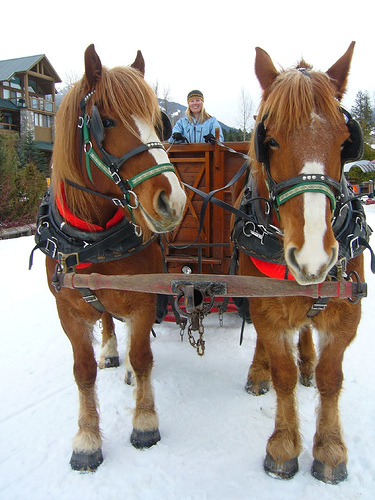

In [43]:
description = description.replace("startseq ", "")
description = description.replace(" endseq", "")
tts = gTTS(description) 
tts.save('tts.mp3') 
display(Image('/content/drive/My Drive/IC/testing.jpg'))
IPython.display.Audio('tts.mp3')